In [68]:
# Module 1: 初始化和设置
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.font_manager as fm

# 配置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans', 'Heiti TC', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 设置图表样式为白色背景
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 设置 Tushare Token
ts.set_token("d8339493f93227f3831389e97d8505bef834c036d09b0cd70cc4e6a8")
pro = ts.pro_api()

# 设置日期范围（近15年）
end_date = datetime.today()
start_date = end_date - timedelta(days=365*15)
start_date_str = start_date.strftime('%Y%m%d')
end_date_str = end_date.strftime('%Y%m%d')

In [69]:
# Module 2: 检查中文字体支持

def check_chinese_fonts():
    """检查系统中可用的中文字体"""
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    chinese_fonts = ['SimHei', 'Arial Unicode MS', 'Heiti TC', 'STHeiti', 'PingFang SC', 'Microsoft YaHei']

    print("检查中文字体支持:")
    found_fonts = []
    for font in chinese_fonts:
        if font in available_fonts:
            found_fonts.append(font)
            print(f"✓ 找到字体: {font}")
        else:
            print(f"✗ 未找到字体: {font}")

    if found_fonts:
        print(f"\n建议使用字体: {found_fonts[0]}")
        plt.rcParams['font.sans-serif'] = [found_fonts[0]] + plt.rcParams['font.sans-serif']
    else:
        print("\n警告: 未找到推荐的中文字体，可能会显示方块字符")
        print("建议安装中文字体或使用其他解决方案")

    return found_fonts

# 检查并设置中文字体
check_chinese_fonts()


检查中文字体支持:
✗ 未找到字体: SimHei
✓ 找到字体: Arial Unicode MS
✓ 找到字体: Heiti TC
✗ 未找到字体: STHeiti
✗ 未找到字体: PingFang SC
✗ 未找到字体: Microsoft YaHei

建议使用字体: Arial Unicode MS


['Arial Unicode MS', 'Heiti TC']

In [70]:
def get_margin_mv_data(exchange):
    # 获取融资余额数据
    df_margin = pro.margin(
        exchange_id=exchange,
        start_date=start_date_str,
        end_date=end_date_str
    )
    
    df_margin = df_margin[['trade_date', 'rzye']].copy()
    df_margin['trade_date'] = pd.to_datetime(df_margin['trade_date'])
    df_margin.sort_values('trade_date', inplace=True)

    # 获取市值数据
    if exchange == 'SSE':
        ts_code = '000001.SH'  # 上证指数
    else:
        ts_code = '399001.SZ'  # 深证成指

    df_mv = pro.index_dailybasic(
        ts_code=ts_code,
        start_date=start_date_str,
        end_date=end_date_str
    )
    df_mv = df_mv[['trade_date', 'float_mv']].copy()
    df_mv['trade_date'] = pd.to_datetime(df_mv['trade_date'])
    df_mv.sort_values('trade_date', inplace=True)

    # 严格按日期内连接，确保同日数据匹配
    df = pd.merge(df_margin, df_mv, on='trade_date', how='inner')
    df.dropna(inplace=True)

    return df


In [71]:
# Module 6: 合并SSE与SZSE，并计算总指标（严格按日对齐）

def get_both_exchanges_df():
    # 获取两市数据
    df_sse_raw = get_margin_mv_data('SSE').rename(columns={'rzye': 'rzye_sse', 'float_mv': 'float_mv_sse'})
    df_szse_raw = get_margin_mv_data('SZSE').rename(columns={'rzye': 'rzye_szse', 'float_mv': 'float_mv_szse'})

    # 严格按日期内连接，保留两市共同有数据的交易日
    df_merged = pd.merge(df_sse_raw, df_szse_raw, on='trade_date', how='inner')

    # 计算总融资余额、总流通市值
    df_merged['rzye_total'] = df_merged[['rzye_sse', 'rzye_szse']].sum(axis=1, skipna=True)
    df_merged['float_mv_total'] = df_merged[['float_mv_sse', 'float_mv_szse']].sum(axis=1, skipna=True)

    # 计算总比值
    df_merged['ratio_total'] = df_merged['rzye_total'] / df_merged['float_mv_total']

    # 排序并返回
    df_merged = df_merged.sort_values('trade_date').reset_index(drop=True)

    return df_merged[['trade_date', 'rzye_sse', 'float_mv_sse', 'rzye_szse', 'float_mv_szse', 'rzye_total', 'float_mv_total', 'ratio_total']]

# 运行并查看结果
both_df = get_both_exchanges_df()
both_df.head()


,trade_date,rzye_sse,float_mv_sse,rzye_szse,float_mv_szse,rzye_total,float_mv_total,ratio_total
0,2013-05-02,1.221979e+11,1.299425e+13,5.338927e+10,1.265574e+12,1.755871e+11,1.425983e+13,0.012313
1,2013-05-03,1.218870e+11,1.318371e+13,5.341288e+10,1.284887e+12,1.752999e+11,1.446860e+13,0.012116
2,2013-05-06,1.233611e+11,1.333888e+13,5.466992e+10,1.308202e+12,1.780311e+11,1.464708e+13,0.012155
3,2013-05-07,1.242703e+11,1.335968e+13,5.531495e+10,1.311498e+12,1.795853e+11,1.467118e+13,0.012241
4,2013-05-08,1.248881e+11,1.341827e+13,5.567588e+10,1.317080e+12,1.805640e+11,1.473535e+13,0.012254


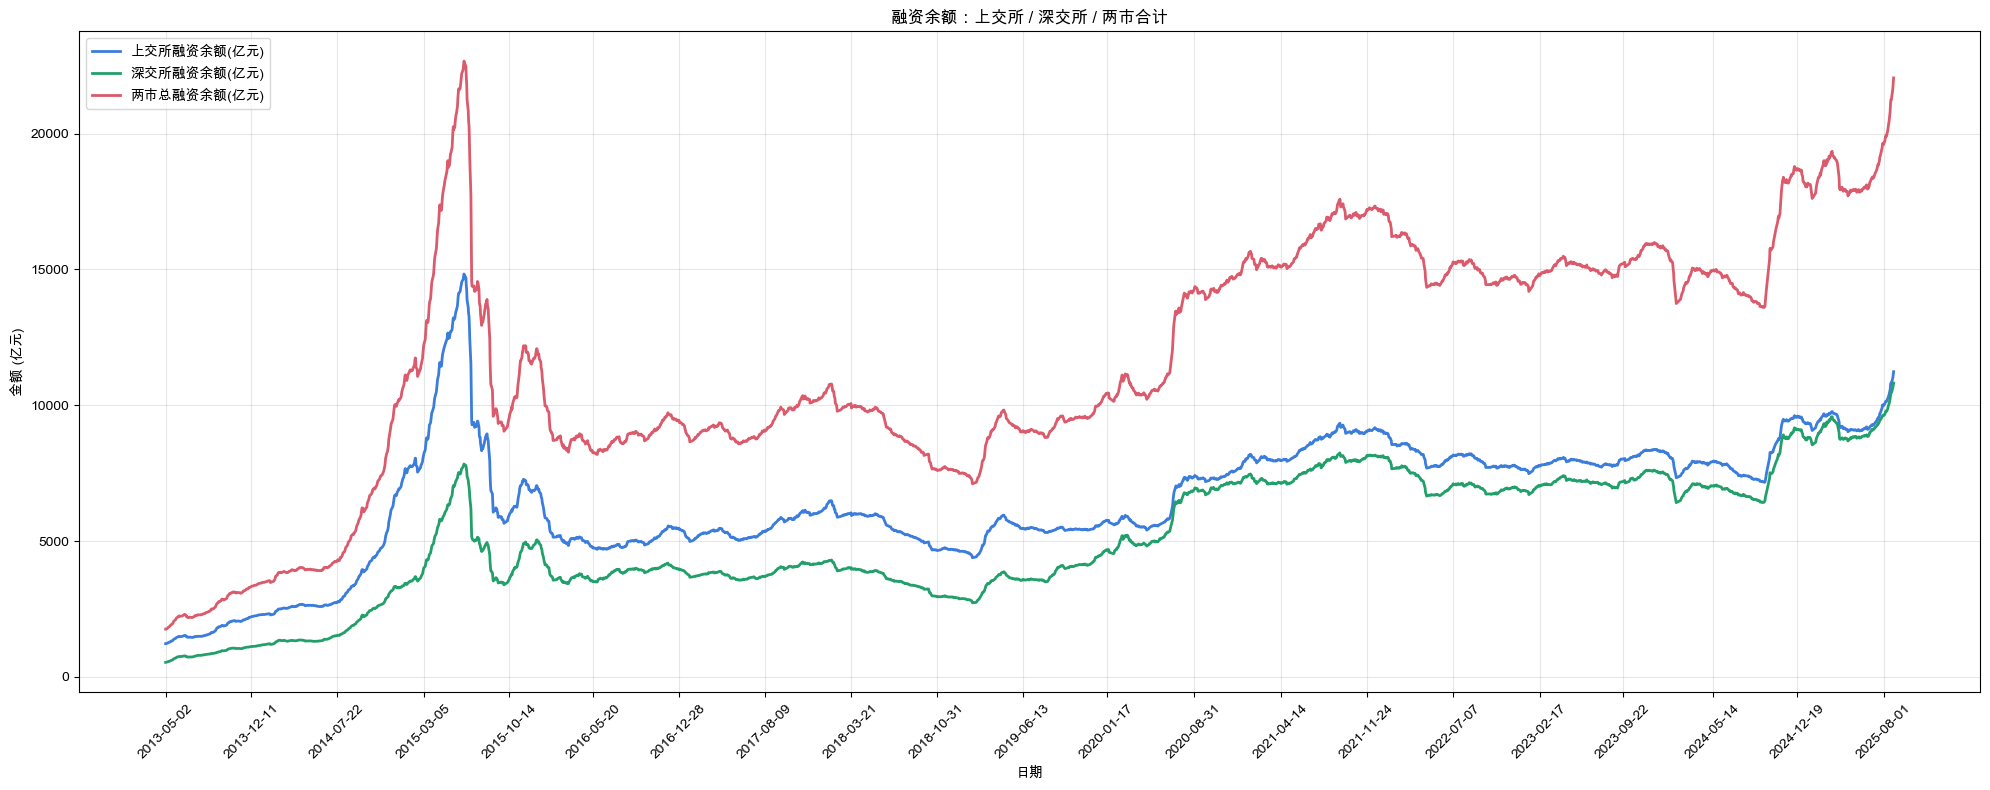

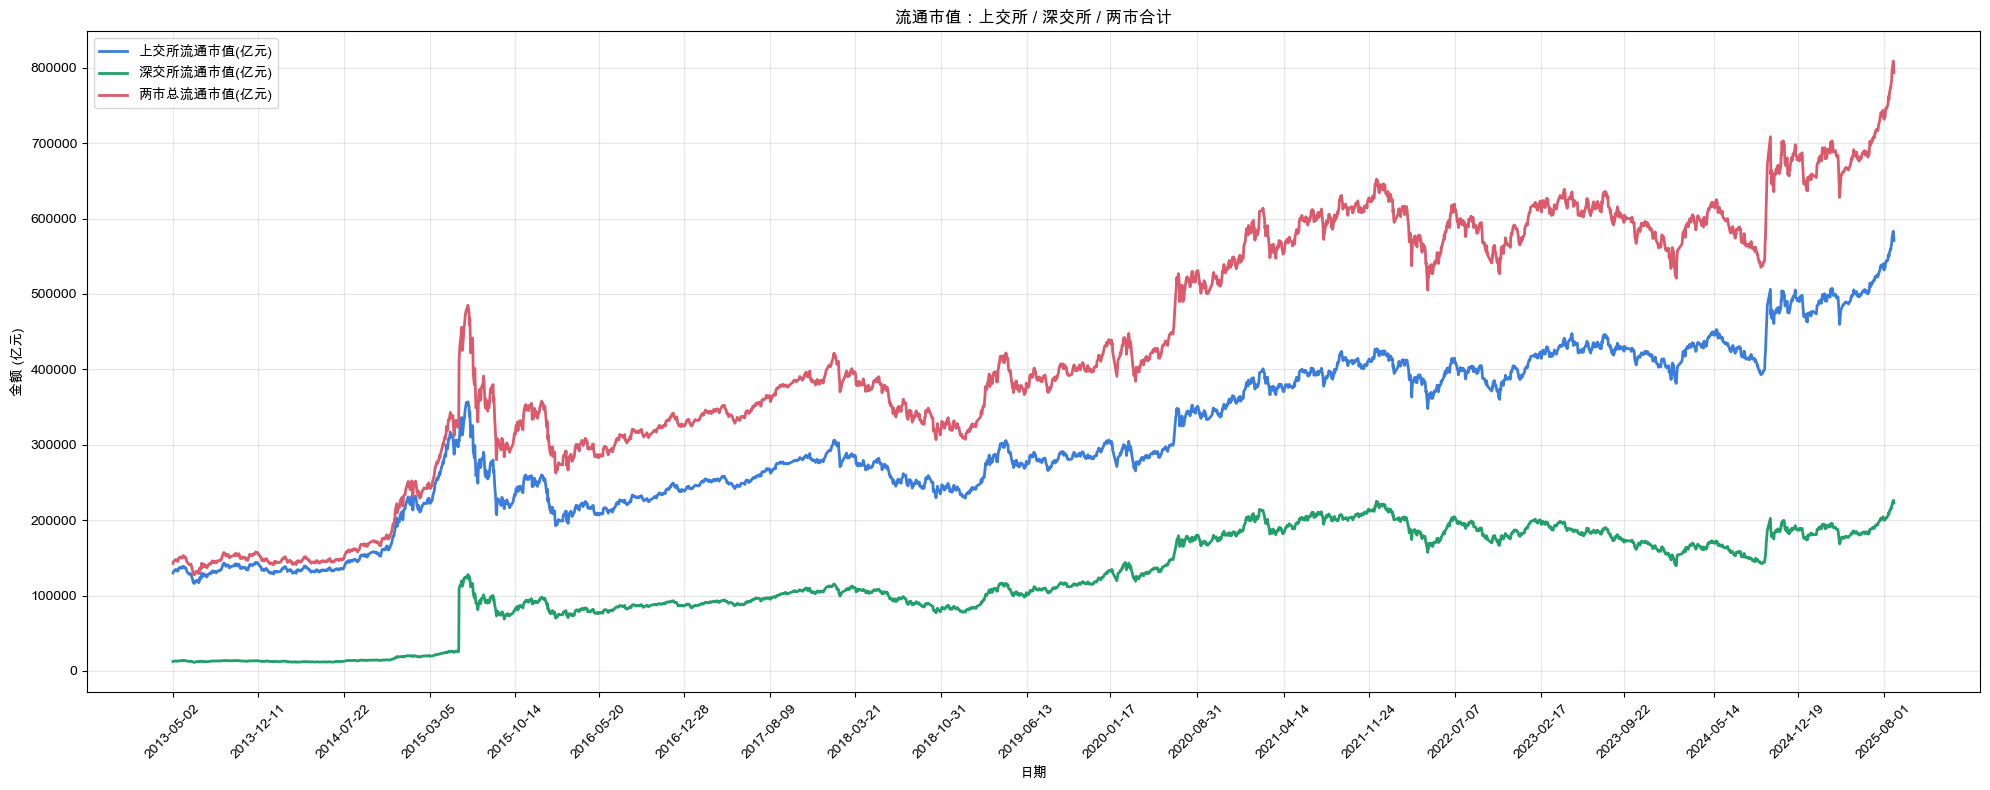

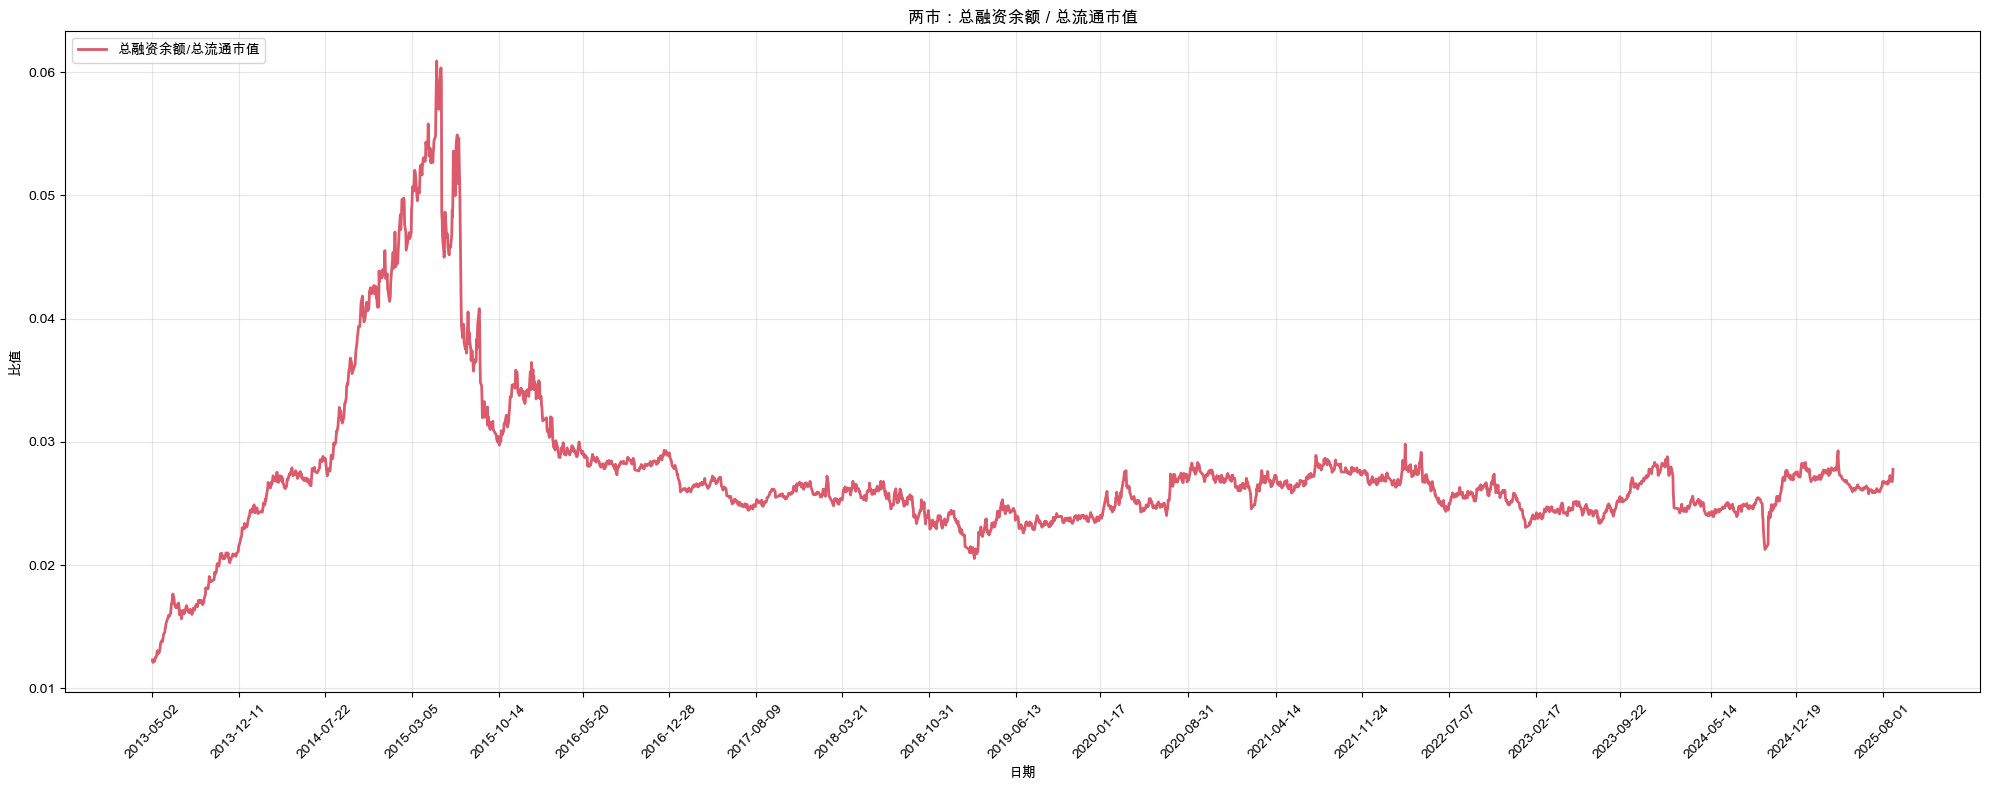

In [72]:
# Module 7: 绘制三张图

def plot_three_charts(df):
    # 采样间隔，保证横轴可读性
    interval = max(1, len(df) // 20)
    x_dates = df['trade_date']
    x_labels = df['trade_date'].dt.strftime('%Y-%m-%d')
    x_ticks = x_dates[::interval]
    x_labels_sampled = x_labels[::interval]

    # 1) 融资余额（三线）
    plt.figure(figsize=(20, 8))
    plt.plot(df['trade_date'], df['rzye_sse'] / 1e8, label='上交所融资余额(亿元)', color='#3b7ddd', linewidth=2)
    plt.plot(df['trade_date'], df['rzye_szse'] / 1e8, label='深交所融资余额(亿元)', color='#22a06b', linewidth=2)
    plt.plot(df['trade_date'], df['rzye_total'] / 1e8, label='两市总融资余额(亿元)', color='#db5a6b', linewidth=2)
    plt.xticks(ticks=x_ticks, labels=x_labels_sampled, rotation=45)
    plt.xlabel('日期')
    plt.ylabel('金额 (亿元)')
    plt.title('融资余额：上交所 / 深交所 / 两市合计')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2) 流通市值（三线，含合计）
    plt.figure(figsize=(20, 8))
    plt.plot(df['trade_date'], df['float_mv_sse'] / 1e8, label='上交所流通市值(亿元)', color='#3b7ddd', linewidth=2)
    plt.plot(df['trade_date'], df['float_mv_szse'] / 1e8, label='深交所流通市值(亿元)', color='#22a06b', linewidth=2)
    plt.plot(df['trade_date'], df['float_mv_total'] / 1e8, label='两市总流通市值(亿元)', color='#db5a6b', linewidth=2)
    plt.xticks(ticks=x_ticks, labels=x_labels_sampled, rotation=45)
    plt.xlabel('日期')
    plt.ylabel('金额 (亿元)')
    plt.title('流通市值：上交所 / 深交所 / 两市合计')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 3) 总融资余额 / 总流通市值（单线）
    plt.figure(figsize=(20, 8))
    plt.plot(df['trade_date'], df['ratio_total'], label='总融资余额/总流通市值', color='#db5a6b', linewidth=2)
    plt.xticks(ticks=x_ticks, labels=x_labels_sampled, rotation=45)
    plt.xlabel('日期')
    plt.ylabel('比值')
    plt.title('两市：总融资余额 / 总流通市值')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# 执行绘制
plot_three_charts(both_df)